In [233]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [234]:
class Node:
    #Create Node class for Map
    def __init__(self, x, y, name):
        self.name = name
        self.x = x
        self.y = y
        self.connections = 0
        self.neighbours = set()


#Identical to Node class but a different object type
class Source(Node):
    def __init__(self, x, y, name):
        super().__init__(x, y, name)

#Inherits from node and adds a random urgency val
class Destination(Node):
    def __init__(self, x, y, name):
        super().__init__(x, y, name)
        self.urgency = np.random.randint(1, 6)

#Creates an arc class for map with a random traffic val
class Arc:
    def __init__(self, a, b):
        self.a = a
        self.b = b
        self.dist = np.sqrt((a.x - b.x)**2 + (a.y - b.y)**2)
        self.traffic = np.random.randint(1, 6)
        self.cost = self.dist * (self.traffic * 0.75)

In [235]:
def dist(a, b):
    """
    Calculates the Euclidean distance between two nodes.

    Parameters:
    a (Node): The first node.
    b (Node): The second node.

    Returns:
    float: The Euclidean distance between the two nodes.
    """
    return np.sqrt((a.x - b.x)**2 + (a.y - b.y)**2)

def find_closest(node, nodes):
    """
    Finds the closest node to a given node.

    Parameters:
    node (Node): The node for which the closest node needs to be found.
    nodes (list): A list of nodes.

    Returns:
    Node: The closest node to the given node.
    """
    min_distance = float('inf')  # Initialize the minimum distance
    closest_node = None  # Initialize the closest node variable

    # Iterate through each node in the list of nodes
    for other_node in nodes:
        if other_node != node:  # Skip the current node itself
            distance = dist(node, other_node)  # Calculate the distance between the current node and other_node
            if distance < min_distance:  # If the distance is less than the minimum distance found so far
                min_distance = distance  # Update the minimum distance
                closest_node = other_node  # Update the closest node

    return closest_node  # Return the closest node

In [236]:
#Creates the state space
def create_map(width, height, destination_num, node_num, max_arc_dist, max_connections, norm_sep, source_sep, dest_sep):
    """
    Creates the state space for the pathfinding algorithms.

    Parameters:
    width (float): The width of the state space.
    height (float): The height of the state space.
    destination_num (int): The number of destination nodes to be generated.
    node_num (int): The total number of nodes to be generated.
    max_arc_dist (float): The maximum distance between nodes to form a connection.
    max_connections (int): The maximum number of connections each node can have.
    norm_sep (float): The minimum separation between normal nodes.
    source_sep (float): The separation between the source node and other nodes.
    dest_sep (float): The minimum separation between destination nodes.

    Returns:
    tuple: A tuple containing the source node, a list of all nodes, a list of arcs, and a list of destination nodes.
    """

    # Empty lists to hold generated data
    nodes = []
    destinations = []
    arcs = []

    # Temporary destination node to prevent an empty array error in the for loop when placing destinations
    destinations.append(Destination(width/2, height/2, 0))
    place_holder_removed = False

    # Creates a central source node
    source = Source(width/2, height/2, 1)
    nodes.append(source)

    # Creates 4 nodes and connections to create a map to build from
    nodes.append(Node(source.x, source.y + source_sep, 2))
    arcs.append(Arc(source, nodes[1]))

    nodes.append(Node(source.x, source.y - source_sep, 3))
    arcs.append(Arc(source, nodes[2]))

    nodes.append(Node(source.x + source_sep, source.y, 4))
    arcs.append(Arc(source, nodes[3]))

    nodes.append(Node(source.x - source_sep, source.y, 5))
    arcs.append(Arc(source, nodes[4]))

    # Update arcs held variables
    for arc in arcs:
        arc.a.connections += 1
        arc.b.connections += 1
        arc.a.neighbours.add(arc.b)
        arc.b.neighbours.add(arc.a)
    
    # Create a variable to hold node names
    node_name = len(nodes)

    # Loop to place destinations
    for _ in range(destination_num):
        while True:
            # Create a temporary destination with a random position
            temp = Destination(np.random.uniform(0, width), np.random.uniform(0, height), node_name)

            # If temp is far enough away from other nodes based on passed variables
            if ((dist(source, temp) > source_sep * 3.5) and (min(dist(temp, dest) for dest in destinations) > dest_sep)
                 and (min(dist(temp, node) for node in nodes) > norm_sep)):
                # Add destination to arrays
                nodes.append(temp)                
                destinations.append(temp)
                node_name += 1

                # Remove placeholder if needed
                if not place_holder_removed:
                    destinations.pop(0)
                    place_holder_removed = True
                break

    # Loop to create normal nodes
    for _ in range(5, node_num):
        while True:
            # Create a temporary node with a random position
            temp = Node(np.random.uniform(0, width), np.random.uniform(0, height), node_name)
            # If temp is far enough away from other nodes based on passed variables
            if ((dist(source, temp) > source_sep) and (min(dist(temp, node) for node in nodes) > norm_sep)):
                # Add to array
                nodes.append(temp)
                node_name += 1
                break

    # Generate connections between nodes
    for node in nodes:
        for target in nodes:
            # If nodes are unique and within the maximum distance
            if ((node != target) and (node.connections < max_connections) and (target.connections < max_connections)):
                # If distance between nodes is less than the maximum
                if (dist(node, target) < max_arc_dist):
                    # Create arc and add to array
                    arc = Arc(node, target)
                    arcs.append(arc)
                    # Update each node's variables
                    node.connections += 1
                    node.neighbours.add(target)
                    target.connections += 1
                    target.neighbours.add(node)

    # Looking for nodes with no connections
    for node in nodes:
        if node.connections == 0:
            target = find_closest(node, nodes)
            # If the distance is less than 2 * the previously used maximum
            if (dist(node, target) < 2 * max_arc_dist):
                # Create arc and add to array
                arc = Arc(node, target)
                arcs.append(arc)
                # Update each node's variables
                node.connections += 1
                node.neighbours.add(target)
                target.connections += 1
                target.neighbours.add(node)

    return source, nodes, arcs, destinations


In [237]:
def plot_map(nodes, arcs, path):
    """
    Plots a map with nodes, arcs, and an optional path.

    Parameters:
    nodes (list): List of node objects. Nodes can be of type Source, Destination, or other.
    arcs (list): List of arc objects. Each arc connects two nodes and has a traffic attribute.
    path (list): Optional list of nodes representing a path. If provided, the path will be plotted.
    """

    # Define colors for the colormap (blue and red) and create the colormap
    colours = [(0, 0, 1, 1), (1, 0, 0, 1)]
    cmap_name = 'traffic'
    cmap = LinearSegmentedColormap.from_list(cmap_name, colours)

    # Plot each node
    for node in nodes:
        if isinstance(node, Source):
            # Plot source nodes in lime color
            plt.scatter(node.x, node.y, color='lime', label='Source')
        elif isinstance(node, Destination):
            # Plot destination nodes in cyan color and add a label with the node name
            plt.scatter(node.x, node.y, color='cyan', label='Destination')
            plt.text(node.x, node.y, str(node.name), fontsize=12, ha='center', va='center', color='magenta')
        else:
            # Plot other nodes in black color
            plt.scatter(node.x, node.y, color='black')

    # Plot each arc
    for arc in arcs:
        # Normalize traffic level to [0, 1] and get the corresponding color from the colormap
        traffic = arc.traffic
        color = cmap(traffic / 5)
        # Plot the arc as a line between the two nodes it connects
        plt.plot([arc.a.x, arc.b.x], [arc.a.y, arc.b.y], color=color)

    # If a path is provided, plot it
    if path:
        # Extract x and y coordinates of the nodes in the path
        path_x = [node.x for node in path]
        path_y = [node.y for node in path]
        # Plot the path as a limegreen line
        plt.plot(path_x, path_y, color='limegreen')

    # Add labels and title to the plot
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('State Space')
    # Display the plot
    plt.show()


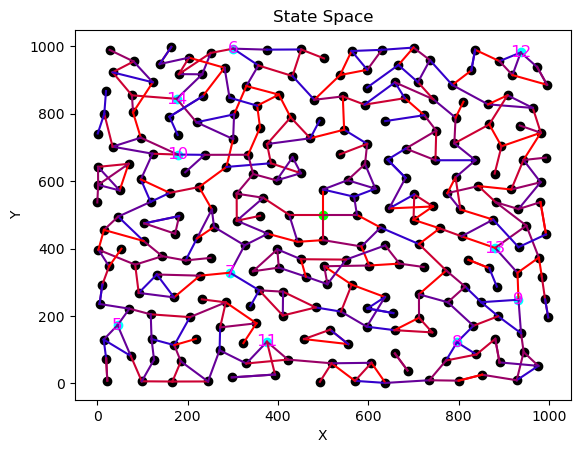

In [238]:
# w, h, dest_num, node_num, max_arc_dist, max_connections, norm_sep, source_sep, dest_sep
source, nodes, arcs, destinations = create_map(1000, 1000, 10, 250, 100, 3, 50, 75, 125)
plot_map(nodes, arcs, None)

In [239]:
#A* Pathfinding Alg

In [240]:
#Class for a drone using A*
class AS_Drone:
    def __init__(self, a, b):
        self.a = a
        self.b = b
        self.path = []

In [241]:
def reconstruct_path(previous, current_node):
    """
    Reconstructs the path from the start node to the current node.

    Parameters:
    previous (dict): A dictionary where keys are nodes and values are the preceding nodes in the path.
    current_node: The current node from which the path reconstruction begins.

    Returns:
    list: A list of nodes representing the reconstructed path from start to current_node.
    """

    total_path = [current_node]  # Initialize the path with the current node

    # Traverse back from the current node to the start node using the previous dictionary
    while current_node in previous:
        current_node = previous[current_node]  # Move to the preceding node
        total_path.insert(0, current_node)  # Insert the node at the beginning of the path

    return total_path  # Return the reconstructed path


In [242]:
def get_arc(a, b, arcs):
    """
    Retrieves the arc connecting two nodes if it exists.

    Parameters:
    a: The first node.
    b: The second node.
    arcs (list): List of arc objects. Each arc connects two nodes (arc.a and arc.b).

    Returns:
    arc: The arc object connecting nodes a and b.

    Raises:
    ValueError: If no arc connects the nodes a and b.
    """

    # Iterate through the list of arcs to find the arc connecting nodes a and b
    for arc in arcs:
        if (((arc.a == a) & (arc.b == b)) or ((arc.a == b) & (arc.b == a))):
            return arc  # Return the arc if found

    # Raise an error if no arc connecting a and b is found
    raise ValueError('no arc')

In [243]:
def heuristic_cost(current_node, other_node, goal_node):
    """
    Calculates the heuristic cost from the current node to another node considering the traffic.

    Parameters:
    current_node: The current node in the path.
    other_node: The neighboring node to which the cost is being calculated.
    goal_node: The goal node for the pathfinding algorithm.

    Returns:
    float: The heuristic cost from the current node to the other node.
    """

    # Calculate the Euclidean distance from the other node to the goal node
    euc_distance = dist(other_node, goal_node)
    
    # Retrieve the arc connecting the current node and the other node
    arc = get_arc(current_node, other_node, arcs)
    
    # Calculate the traffic factor (squared traffic level multiplied by 0.5)
    traffic = (arc.traffic ** 2) * 0.5

    # Return the heuristic cost as the product of the Euclidean distance and the traffic factor
    return euc_distance * traffic


def a_star(courier, nodes):
    """
    Performs the A* search algorithm to find the shortest path from the courier's start node to the goal node.

    Parameters:
    courier: An object with attributes 'a' (start node) and 'b' (goal node).
    nodes (list): List of all nodes in the graph.

    Returns:
    tuple: A tuple containing the reconstructed path (list of nodes) and the cost of the path (float).
           If no path is found, returns (None, float('inf')).
    """

    start_node = courier.a
    goal_node = courier.b

    closed_set = set()  # Set of nodes already evaluated
    open_set = {start_node}  # Set of nodes to be evaluated, starting with the start node
    previous = {}  # Dictionary to keep track of the most efficient previous step

    # Dictionary to keep track of the cost of the cheapest path from start to each node
    g_score = {node: float('inf') for node in nodes}
    g_score[start_node] = 0

    # Dictionary to keep track of the estimated total cost from start to goal through each node
    f_score = {node: float('inf') for node in nodes}
    f_score[start_node] = dist(start_node, goal_node)

    while open_set:
        # Current node is the node in open_set with the lowest f_score value
        current = min(open_set, key=lambda node: f_score[node])
        
        # If the current node is the goal, reconstruct and return the path and its cost
        if current == goal_node:
            return reconstruct_path(previous, goal_node), g_score[current]

        open_set.remove(current)  # Remove current from open_set
        closed_set.add(current)  # Add current to closed_set

        for neighbour in current.neighbours:
            if neighbour in closed_set:
                continue  # Ignore the neighbour which is already evaluated

            # Calculate the tentative g_score
            tentative_g_score = g_score[current] + get_arc(current, neighbour, arcs).cost

            if tentative_g_score < g_score[neighbour]:
                # This path to neighbour is the best so far
                previous[neighbour] = current  # Record the best path to neighbour

                g_score[neighbour] = tentative_g_score  # Update g_score for neighbour
                f_score[neighbour] = tentative_g_score + heuristic_cost(current, neighbour, goal_node)  # Update f_score for neighbour

                if neighbour not in open_set:
                    open_set.add(neighbour)  # Add the neighbour to open_set if not already present

    # If we reach here, it means there is no path from start to goal
    return None, float('inf')


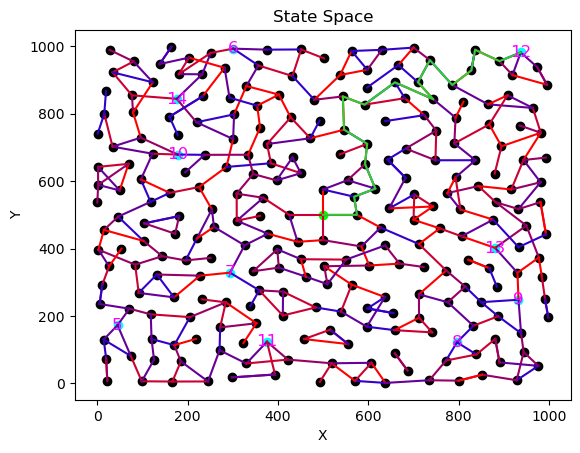

In [244]:
#Create drone object
drone = AS_Drone(source, np.random.choice(destinations))

path, length = a_star(drone, nodes)

plot_map(nodes, arcs, path)

In [245]:
#Genetic Alg

In [246]:
#Class for a drone using GA that inherits from the A* drone
class Gen_Drone(AS_Drone):
    def __init__(self, order, fitness):
        self.order = order

        if fitness == None:
            self.fitness = float('inf')
        else:
            self.fitness = fitness

#Class for holding the best path between two nodes
class Dest_Path:
    def __init__(self, a, b, path):
        self.a = a
        self.b = b
        self.path = path

In [247]:
def init_pop(pop_size, dests):
    """
    Initializes a population for a genetic algorithm.

    Parameters:
    pop_size (int): The size of the population to be generated.
    dests (list): List of destinations to be included in each individual's route.

    Returns:
    list: A list of Gen_Drone objects representing the initial population.
    """

    pop = []

    for i in range(pop_size):
        np.random.shuffle(dests)  # Shuffle the destinations to create a random route
        pop.append(Gen_Drone(dests, None))  # Create a Gen_Drone object with the shuffled route and add it to the population

    return pop  # Return the initialized population

        

In [248]:
def build_path(drone, best_dests):
    """
    Constructs the path for the drone based on the best destinations and the drone's order.

    Parameters:
    drone: The drone object which has an order attribute specifying the sequence of destinations.
    best_dests (list): List of path objects, each containing nodes and information about the path between destinations.

    Returns:
    list: A list of nodes representing the complete path for the drone.
    """

    drone_path = []  # Initialize an empty list to store the drone's path
    current = nodes[0]  # Start from the first node in the list of nodes

    # Iterate through each destination in the drone's order
    for next in drone.order:
        
        # Find the best path from the current node to the next destination
        for path in best_dests:
            if path.a == current and path.b == next:
                current = path.path[-1]  # Update the current node to the last node in the found path
                
                # Append each node in the found path to the drone's path, except the last node
                for node in path.path:
                    if node != path.path[-1]:
                        drone_path.append(node)
                break

    # Append the final destination to the drone's path
    drone_path.append(next)

    return drone_path  # Return the complete path for the drone



def path_len(path):
    """
    Calculates the total length (cost) of a given path.

    Parameters:
    path (list): A list of nodes representing the path.

    Returns:
    float: The total length (cost) of the path.
    """

    tot = 0  # Initialize the total length variable to zero
    
    # Iterate through each node in the path (except the last one)
    for i in range(len(path)-1):
        # Add the actual cost of moving from the current node to the next node to the total length
        tot += get_arc(path[i], path[i+1], arcs).cost
    
    return tot  # Return the total length of the path


In [249]:
def fitness_func(pop, best_dests):
    """
    Calculates the fitness value for each drone in the population.

    Parameters:
    pop (list): A list of Gen_Drone objects representing the population.
    best_dests (list): List of path objects, each containing nodes and information about the path between destinations.
    dests (list): List of all destination nodes.

    Returns:
    None
    """

    # Iterate through each drone in the population
    for drone in pop:
        # Build the path for the current drone based on the best destinations
        path = build_path(drone, best_dests)
        
        # Calculate the total cost of the path
        path_cost = path_len(path)
        
        urgency_cost = 0  # Initialize the urgency cost variable to zero
        next_dest_idx = 0

        # Iterate through each node in the path
        for i in range(len(path)):
            # If the current node is the next destination node, calculate its urgency cost
            if path[i] == drone.order[next_dest_idx]:
                # Urgency cost is the urgency of the node multiplied by i raised to the power of 3
                urgency_cost += (path[i].urgency) * (i**3)
                next_dest_idx += 1

        # Calculate the fitness value for the drone as the sum of path cost and urgency cost
        drone.fitness = path_cost + urgency_cost


In [250]:
def crossover(pop, tournament_size):
    """
    Performs crossover operation to generate a new population.

    Parameters:
    pop (list): A list of Gen_Drone objects representing the current population.
    tournament_size (int): The number of individuals to participate in each tournament selection.

    Returns:
    list: A list of new Gen_Drone objects representing the new population after crossover.
    """

    new_pop = []  # Initialize an empty list to store the new population

    # Iterate through each individual in the current population
    for i in range(len(pop)):

        # Select parents for crossover using tournament selection
        order_a = select_parent(pop, tournament_size).order
        order_b = select_parent(pop, tournament_size).order

        # Select a random crossover point
        crossover_point = random.randint(0, len(order_a)-1)
        
        # Determine the nodes to add to the offspring from parent B that are not already in the offspring
        nodes_to_add = np.setdiff1d(order_b, order_a[:crossover_point], assume_unique=True)
        
        # Concatenate the first part of parent A's order with the nodes from parent B
        new_order = np.concatenate((order_a[:crossover_point], nodes_to_add))
        
        # Create a new Gen_Drone object with the new order and a placeholder fitness value
        new_pop.append(Gen_Drone(new_order, float('inf')))
        
    return new_pop  # Return the new population




def select_parent(pop, tournament_size):
    """
    Selects a parent from the population using tournament selection.

    Parameters:
    pop (list): A list of Gen_Drone objects representing the population.
    tournament_size (int): The number of individuals to participate in the tournament.

    Returns:
    Gen_Drone: The selected parent.
    """

    # Choose random indices for the tournament from the population
    tournament_indices = np.random.choice(len(pop), tournament_size, replace=False)
    
    # Create a tournament by selecting individuals from the population based on the chosen indices
    tournament = [pop[idx] for idx in tournament_indices]
    
    # Select the parent with the minimum fitness value from the tournament
    parent = min(tournament, key=lambda x: x.fitness)
    
    return parent  # Return the selected parent


In [251]:
def mutate(pop, mutation_rate):
    """
    Mutates individuals in the population with a given mutation rate.

    Parameters:
    pop (list): A list of Gen_Drone objects representing the population.
    mutation_rate (float): The probability of mutation for each individual.

    Returns:
    None
    """

    # Iterate through each drone in the population
    for drone in pop:
        # Check if the drone should undergo mutation based on the mutation rate
        if random.uniform(0, 1) < mutation_rate:
            # Choose two distinct indices for mutation
            x, y = np.random.choice(len(drone.order), 2, replace=False)
            # Mutate the order by removing element at index x and inserting it at index y
            drone.order = np.insert(np.delete(drone.order, x), y, drone.order[x])


In [252]:
def gen_alg(generations, pop_size, dest_num, tournament_size, mutation_rate):
    """
    Runs a genetic algorithm to optimize drone routes.

    Parameters:
    generations (int): The number of generations for the genetic algorithm.
    pop_size (int): The size of the population.
    dest_num (int): The number of destinations.
    tournament_size (int): The size of the tournament for parent selection.
    mutation_rate (float): The probability of mutation for each individual.

    Returns:
    tuple: A tuple containing the best chromosome (Gen_Drone object) and the best destination paths (list of Dest_Path objects).
    """

    best_dests = []  # Initialize an empty list to store the best destination paths
    dests = np.random.choice(destinations, dest_num, replace=False)  # Randomly select destination nodes

    # Generate best destination paths for each pair of destinations
    for i in range(dest_num):
        # Find the best path from the start node to the current destination
        temp = AS_Drone(nodes[0], dests[i])
        path, _ = a_star(temp, nodes)
        best_path = Dest_Path(nodes[0], dests[i], path)
        best_dests.append(best_path)  # Add the best path to the list of best destination paths

        # Find the best path between each pair of destinations (excluding self-pairs)
        for j in range(dest_num):
            if not dests[i] == dests[j]:
                temp = AS_Drone(dests[i], dests[j])
                path, _ = a_star(temp, nodes)
                best_path = Dest_Path(dests[i], dests[j], path)
                best_dests.append(best_path)  # Add the best path to the list of best destination paths

    best_chromo = Gen_Drone(None, None)  # Initialize the best chromosome

    pop = init_pop(pop_size, dests)  # Initialize the population

    # Iterate through each generation
    for i in range(generations):
        fitness_func(pop, best_dests)  # Calculate fitness for each individual in the population
        pop = sorted(pop, key=lambda x: x.fitness)  # Sort the population based on fitness

        # Update the best chromosome if a better solution is found
        if pop[0].fitness < best_chromo.fitness:
            best_chromo.fitness = pop[0].fitness
            best_chromo.order = pop[0].order
            
            # Print the best fitness and corresponding order
            print('Gen:', i, '= ', best_chromo.fitness, ': ', ', '.join(f"{x.name}({x.urgency})" for x in best_chromo.order))

        crossover(pop, tournament_size)  # Perform crossover operation
        mutate(pop, mutation_rate)  # Perform mutation operation


    return best_chromo, best_dests  # Return the best chromosome and the best destination paths



Gen: 0 =  596014.9786857943 :  8(2), 10(1), 14(4), 6(4), 5(1)
Gen: 3 =  417035.81040887954 :  10(1), 14(4), 6(4), 5(1), 8(2)
Gen: 5 =  286698.7799312416 :  14(4), 6(4), 10(1), 5(1), 8(2)
Gen: 17 =  277694.0649179668 :  6(4), 14(4), 10(1), 5(1), 8(2)


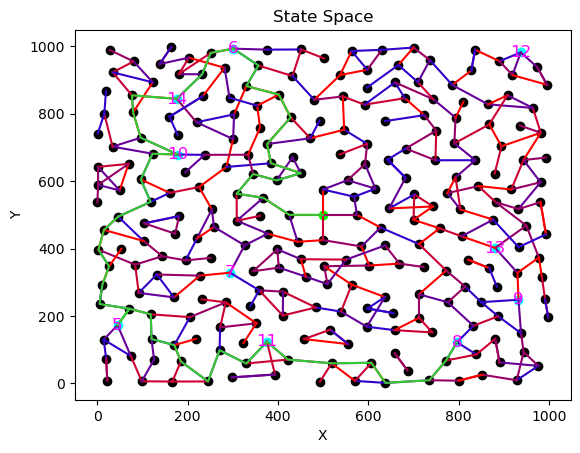

In [253]:
best_chromo, best_dests = gen_alg(50, 25, 5, 2, 0.25)
plot_map(nodes, arcs, build_path(best_chromo, best_dests))

In [254]:
#Ant Colony Optimisation

In [255]:
#Class for an ant
class Ant:
    def __init__(self, source, destination):
        self.source = source
        self.destination = destination
        self.current_node = source
        self.path = [source]
        self.dist = 0
        self.visited = {source}

In [256]:
def init_phero_mat(init_phero):
    """
    Initializes a pheromone matrix with a given initial pheromone level.

    Parameters:
    init_phero (float): The initial pheromone level.

    Returns:
    list: A 2D list representing the pheromone matrix.
    """

    num_nodes = len(nodes)  # Get the number of nodes
    # Initialize the pheromone matrix with the given initial pheromone level
    phero_mat = [[init_phero] * num_nodes for _ in range(num_nodes)]
    return phero_mat  # Return the initialized pheromone matrix



def update_phero(phero_mat, ants, evap_rate, node_idxs):
    """
    Updates the pheromone matrix based on the paths taken by ants.

    Parameters:
    phero_mat (list): A 2D list representing the pheromone matrix.
    ants (list): A list of Ant objects representing the ants.
    evap_rate (float): The evaporation rate of the pheromone.
    node_idxs (dict): A dictionary mapping nodes to their corresponding indices in the pheromone matrix.

    Returns:
    None
    """

    # Evaporate pheromone on all edges
    for i in range(len(phero_mat)):
        for j in range(len(phero_mat[i])):
            phero_mat[i][j] *= (1 - evap_rate)

    # Update pheromone based on the paths taken by ants
    for ant in ants:
        for i in range(len(ant.path) - 1):
            current_node = ant.path[i]
            next_node = ant.path[i+1]
            # Increase pheromone on the edge between current_node and next_node
            phero_mat[node_idxs[current_node]][node_idxs[next_node]] += 1 / ant.dist


In [257]:
def move_ant(ant, phero_mat, alpha, beta, node_idxs):
    """
    Moves an ant to the next node based on the pheromone levels and heuristic information.

    Parameters:
    ant: The Ant object representing the ant.
    phero_mat (list): A 2D list representing the pheromone matrix.
    alpha (float): The importance of pheromone in the decision-making process.
    beta (float): The importance of heuristic information in the decision-making process.
    node_idxs (dict): A dictionary mapping nodes to their corresponding indices in the pheromone matrix.

    Returns:
    Node: The chosen node for the ant to move to.
    """

    current_node = ant.current_node
    allowed_nodes = [node for node in current_node.neighbours if node not in ant.visited]

    # If there are no allowed nodes to move to, return None
    if not allowed_nodes:
        return None

    probs = []  # Initialize a list to store probabilities for each allowed node
    tot_prob = 0  # Initialize the total probability

    # Calculate the probability for each allowed node based on pheromone levels and heuristic information
    for node in allowed_nodes:
        phero = phero_mat[node_idxs[current_node]][node_idxs[node]]  # Pheromone level on the edge
        heuristic_val = (get_arc(current_node, node, arcs).cost) # Heuristic information
        prob = phero ** alpha * heuristic_val ** beta  # Probability calculation
        probs.append((node, prob))
        tot_prob += prob

    # Normalize probabilities
    probs = [(node, prob / tot_prob) for node, prob in probs]

    chosen_node = None  # Initialize the chosen node variable
    rnd_num = random.random()  # Generate a random number between 0 and 1
    cumulative_prop = 0.0  # Initialize the cumulative probability

    # Choose a node based on the calculated probabilities
    for node, prob in probs:
        cumulative_prop += prob
        if rnd_num <= cumulative_prop:
            chosen_node = node
            ant.path.append(chosen_node)  # Add the chosen node to the ant's path
            ant.visited.add(chosen_node)  # Mark the chosen node as visited
            ant.dist += dist(current_node, chosen_node)  # Update the total distance traveled by the ant
            break
    return chosen_node  # Return the chosen node


In [258]:
def ant_CO(source, destination, pop, iterations, alpha, beta, evap_rate):
    """
    Runs the Ant Colony Optimization (ACO) algorithm to find the shortest path from a source node to a destination node.

    Parameters:
    source: The source node.
    destination: The destination node.
    pop (int): The population size (number of ants).
    iterations (int): The number of iterations (epochs) for the algorithm.
    alpha (float): The importance of pheromone in the decision-making process.
    beta (float): The importance of heuristic information in the decision-making process.
    evap_rate (float): The rate at which pheromone evaporates.

    Returns:
    tuple: A tuple containing the best path (list of nodes) and its distance (float).
    """

    best_path = None  # Initialize the best path variable
    best_dist = float('inf')  # Initialize the best distance variable

    # Initialize the pheromone matrix with initial pheromone level 1
    phero_mat = init_phero_mat(100)

    # Create a dictionary mapping nodes to their corresponding indices in the pheromone matrix
    node_idxs = {node: index for index, node in enumerate(nodes)}

    #Create an index where the evap_rate decreases
    thres = int(iterations / 2)

    # Iterate through the specified number of iterations
    for x in range(iterations):
        # Generate a population of ants        
        ants = [Ant(source, destination) for _ in range(pop)]

        #Halfs the evap_rate to enforce exploitation of explored paths
        if (x == thres):
            evap_rate /= 2

        # Move each ant until it reaches the destination node
        for ant in ants:
            while ant.path[-1] != destination:
                next_node = move_ant(ant, phero_mat, alpha, beta, node_idxs)  # Move the ant to the next node

                if next_node:
                    ant.current_node = next_node  # Update the current node of the ant
                else:
                    ant.dist = float('inf')  # Reset the distance of the ant if it gets stuck
                    break
        
        # Update pheromone levels based on ant paths
        update_phero(phero_mat, ants, evap_rate, node_idxs)

        # Find the best ant (shortest path)
        shortest_ant = min(ants, key=lambda ant: ant.dist)
        # Update the best path and distance if a better solution is found
        if shortest_ant.dist < best_dist:
            best_path = shortest_ant.path
            best_dist = shortest_ant.dist
            print('New Best at Iteration: ', x, ': Cost = ', best_dist)

    return best_path, best_dist  # Return the best path and its distance


New Best at Iteration:  2 : Cost =  1080.8433149707232
New Best at Iteration:  4 : Cost =  1029.1175860129074
New Best at Iteration:  7 : Cost =  936.1683446699873
New Best at Iteration:  14 : Cost =  912.2761302658471
New Best at Iteration:  15 : Cost =  821.2284685908419


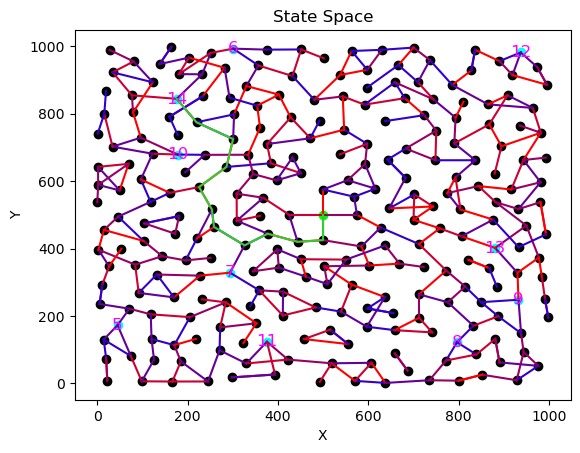

821.23 m


In [262]:
ant_data = ant_CO(source, np.random.choice(destinations), 25, 50, 1, 2, 0.5)

plot_map(nodes, arcs, ant_data[0])
print(np.round(ant_data[1], 2), 'm')